In [35]:
import datetime
import pandas as pd
import pytz
import requests
import time
from io import StringIO

In [115]:
sensor_id_list = ["155565", "163173"]

In [116]:
def get_one_sensor_one_field(sensor_id, start_date, end_date, field="pm2.5_alt"):
    api_headers = {'X-API-Key': 'A9084A32-4059-11EE-A77F-42010A800009'}
    sensor_id_int = int(sensor_id)
    start_date = start_date.timestamp()
    end_date = end_date.timestamp()
    r = requests.get(f"https://api.purpleair.com/v1/sensors/{sensor_id_int}/history/csv", headers=api_headers, params={
        "start_timestamp": start_date,
        "average": 0,
        "end_timestamp": end_date,
        "fields": [field]
    })
    df = pd.read_csv(StringIO(r.text))
    # print(df)
    df = df.sort_values("time_stamp", ascending=True)
    return df

In [121]:
def get_one_sensor_multi_fields(sensor_id, start_date, end_date, fields):
    for field in fields:
        time.sleep(0.5)   # frequently call purpleair api will cause error
        # print(field)
        df = get_one_sensor_one_field(sensor_id, start_date, end_date, field)
        if field == fields[0]:
            df_all = df
        else:
            df_all = df_all.merge(df, on=["time_stamp", "sensor_index"])
    return df_all

In [125]:
sensor_id = sensor_id_list[1]

start_date = datetime.datetime(2023, 10, 16, 14, 0, 0)
end_date = datetime.datetime(2023, 10, 23, 14, 0, 0)

# create a date sequence, since Purple Air API only allows 2 day intervals for real time data
date_sequence = []
while start_date < end_date:
    date_sequence.append(start_date)
    start_date += datetime.timedelta(days=1)
date_sequence.append(end_date)

for i in range(len(date_sequence)-1):
    start_date = date_sequence[i]
    end_date = date_sequence[i+1]
    df = get_one_sensor_multi_fields(sensor_id, start_date, end_date, ["pm2.5_alt", "humidity", "temperature"])
    if i == 0:
        df_all = df
    else:
        df_all = df_all.append(df)
df_all

,time_stamp,sensor_index,pm2.5_alt,humidity,temperature
0,1697490051,163173,1.5,30.0,81.0
1,1697490171,163173,1.6,30.0,81.0
2,1697490290,163173,1.7,30.0,81.0
3,1697490410,163173,1.5,31.0,81.0
4,1697490530,163173,1.3,31.0,81.0
...,...,...,...,...,...
715,1698094306,163173,7.3,48.0,74.0
716,1698094426,163173,7.1,48.0,74.0
717,1698094546,163173,6.5,48.0,75.0
718,1698094666,163173,6.5,48.0,75.0


In [126]:
df_all.to_csv("./data/pa_10162023_10232023_{}.csv".format(sensor_id), index=False)

# Timestamp cleaning

In [183]:
sensor_id_list = ["155565", "163173"]
dfs_processed = {}

In [190]:
sensor_id = sensor_id_list[1]
df = pd.read_csv(f"./data/pa_10162023_10232023_{sensor_id}.csv", index_col=False)
df

,time_stamp,sensor_index,pm2.5_alt,humidity,temperature
0,1697490051,163173,1.5,30.0,81.0
1,1697490171,163173,1.6,30.0,81.0
2,1697490290,163173,1.7,30.0,81.0
3,1697490410,163173,1.5,31.0,81.0
4,1697490530,163173,1.3,31.0,81.0
...,...,...,...,...,...
5020,1698094306,163173,7.3,48.0,74.0
5021,1698094426,163173,7.1,48.0,74.0
5022,1698094546,163173,6.5,48.0,75.0
5023,1698094666,163173,6.5,48.0,75.0


In [191]:
def clean_timestamp(df):
    ts = pd.to_datetime(df["time_stamp"], unit="s") - datetime.timedelta(hours=7)   # convert to PDT
    df["year"] = ts.dt.year
    df["month"] = ts.dt.month
    df["day"] = ts.dt.day
    df["hour"] = ts.dt.hour
    df["minute"] = ts.dt.minute

    df = df.drop(columns=["time_stamp"])

    return df

In [192]:
df_processed = clean_timestamp(df)
df_processed

,sensor_index,pm2.5_alt,humidity,temperature,year,month,day,hour,minute
0,163173,1.5,30.0,81.0,2023,10,16,14,0
1,163173,1.6,30.0,81.0,2023,10,16,14,2
2,163173,1.7,30.0,81.0,2023,10,16,14,4
3,163173,1.5,31.0,81.0,2023,10,16,14,6
4,163173,1.3,31.0,81.0,2023,10,16,14,8
...,...,...,...,...,...,...,...,...,...
5020,163173,7.3,48.0,74.0,2023,10,23,13,51
5021,163173,7.1,48.0,74.0,2023,10,23,13,53
5022,163173,6.5,48.0,75.0,2023,10,23,13,55
5023,163173,6.5,48.0,75.0,2023,10,23,13,57


In [193]:
def average_30min(df):
    df["minute"] = df["minute"].apply(lambda x: 0 if x < 30 else 30)
    df = df.groupby(["year", "month", "day", "hour", "minute"]).mean().reset_index()
    return df

In [194]:
df_processed = average_30min(df_processed)
df_processed

,year,month,day,hour,minute,sensor_index,pm2.5_alt,humidity,temperature
0,2023,10,16,14,0,163173,1.460000,30.733333,81.000000
1,2023,10,16,14,30,163173,1.386667,30.000000,81.000000
2,2023,10,16,15,0,163173,1.220000,30.266667,80.933333
3,2023,10,16,15,30,163173,1.140000,31.866667,80.866667
4,2023,10,16,16,0,163173,1.400000,32.800000,81.000000
...,...,...,...,...,...,...,...,...,...
331,2023,10,23,11,30,163173,5.233333,56.000000,69.000000
332,2023,10,23,12,0,163173,4.800000,54.466667,69.933333
333,2023,10,23,12,30,163173,4.686667,51.066667,71.933333
334,2023,10,23,13,0,163173,6.326667,48.466667,73.466667


In [195]:
df_processed.to_csv(f"./data/pa_10162023_10232023_{sensor_id}(30MinMean).csv", index=False)
dfs_processed[sensor_id] = df_processed

# Visualization

In [200]:
import matplotlib.pyplot as plt
import numpy as np

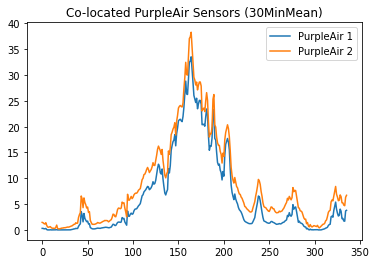

In [199]:
fig, ax = plt.subplots()
ax.plot(dfs_processed["155565"]["pm2.5_alt"], label="PurpleAir 1")
ax.plot(dfs_processed["163173"]["pm2.5_alt"], label="PurpleAir 2")
plt.legend()
plt.title("Co-located Two PurpleAir Sensors (30MinMean)")
plt.show()

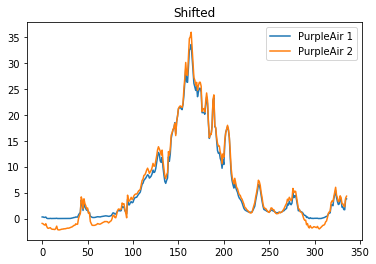

In [201]:
shift = np.mean(dfs_processed["155565"]["pm2.5_alt"]) - np.mean(dfs_processed["163173"]["pm2.5_alt"])
fig, ax = plt.subplots()
ax.plot(dfs_processed["155565"]["pm2.5_alt"], label="PurpleAir 1")
ax.plot(dfs_processed["163173"]["pm2.5_alt"] + shift, label="PurpleAir 2")
plt.legend()
plt.title("Shifted")
plt.show()

In [202]:
dfs_processed["155565"]

,year,month,day,hour,minute,sensor_index,pm2.5_alt,humidity,temperature
0,2023,10,16,14,0,155565,0.300000,30.000000,83.000000
1,2023,10,16,14,30,155565,0.300000,29.200000,83.000000
2,2023,10,16,15,0,155565,0.220000,29.666667,83.000000
3,2023,10,16,15,30,155565,0.220000,31.000000,83.000000
4,2023,10,16,16,0,155565,0.286667,31.866667,83.000000
...,...,...,...,...,...,...,...,...,...
331,2023,10,23,11,30,155565,2.220000,55.933333,70.266667
332,2023,10,23,12,0,155565,1.720000,54.133333,71.133333
333,2023,10,23,12,30,155565,1.686667,51.000000,73.200000
334,2023,10,23,13,0,155565,3.680000,48.266667,74.800000
